In [1]:
import os
import sys
import zipfile
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms,datasets
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [2]:
#extracting the zip file
zip_file = 'archive.zip'
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('data')


In [3]:
#version of the libraries used 
print("Platform:", sys.platform)
print("Python version:", sys.version)
print("---")
print("torch version :",torch.__version__)
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)


Platform: win32
Python version: 3.12.5 (tags/v3.12.5:ff3bc82, Aug  6 2024, 20:45:27) [MSC v.1940 64 bit (AMD64)]
---
torch version : 2.8.0+cpu
pandas version: 2.3.1
numpy version: 2.1.2


In [4]:
#dataset
train_dir=os.path.join('data','train')
test_dir=os.path.join('data','test')

In [6]:
target_var=os.listdir(train_dir)
print(target_var)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [7]:

if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    
else:
    print("gpu is not availale using cpu instead ")

gpu is not availale using cpu instead 


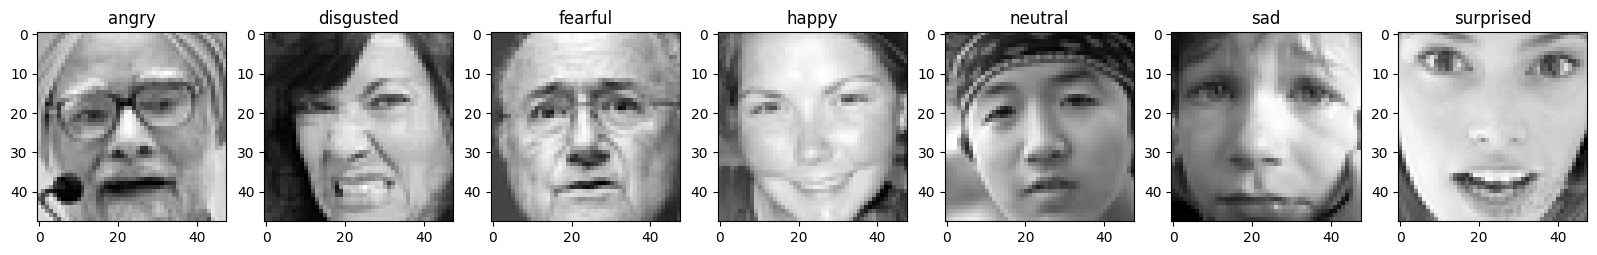

In [8]:
fig, axes=plt.subplots(1,7,figsize=(20,8))
for i in range (len(target_var)):
    
    dir_path=os.path.join(train_dir,target_var[i])
    im_1=os.path.join(dir_path,os.listdir(dir_path)[1])
    img=Image.open(im_1)
    axes[i].imshow(img,cmap='gray')
    axes[i].set_title(target_var[i])
plt.show()    

## Class distriution

In [15]:
lables=[]
counts=[]

for folder in os.listdir(train_dir):
    folder_path=os.path.join(train_dir,folder)
    if os.path.isdir(folder_path):
        lables.append(folder)
        counts.append(len(os.listdir(folder_path)))

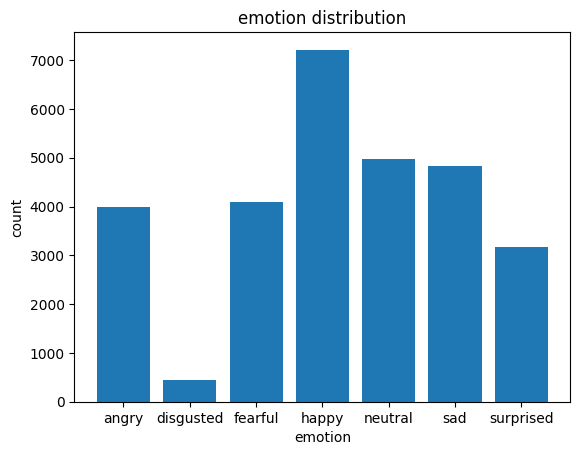

In [19]:
plt.bar(lables,counts)
plt.xlabel('emotion')
plt.ylabel('count')
plt.title('emotion distribution')
plt.show()

## Preprocessing

In [9]:
def get_mean_std(loader):
    channels_sum,channels_ss, num_batches =0, 0 ,0
    for data,_ in loader:
        channels_sum += torch.mean(data,dim=[0,2,3])
        channels_ss +=torch.mean(data ** 2,dim=[0,2,3])
        num_batches+=1
    mean=channels_sum/num_batches
    std=(channels_ss/num_batches-mean **2) ** 0.5

    return mean, std 

In [10]:
#data preprocessing
transform_train=transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    
    transforms.RandomRotation(10),
    transforms.Resize((48,48)),
    
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((48,48),scale=(0.8,1.0)),
    transforms.ToTensor(),
   
])


transform_test=transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48,48)),
    transforms.ToTensor(),
   
])


In [11]:
train_dataset=datasets.ImageFolder(root=train_dir,transform=transform_train)
test_dataset=datasets.ImageFolder(root=test_dir,transform=transform_test)

In [12]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False)

In [13]:
mean,std=get_mean_std(iter(train_loader))

In [14]:
mean_test,std_test=get_mean_std(iter(test_loader))

In [ ]:
class ConvertToRGB:
    def __call__(self, img):
        if img.mode != "RGB":
            img = img.convert("RGB")
        return img

In [20]:
transform_norm_train=transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomRotation(10),
    transforms.Resize((48,48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((48,48),scale=(0.8,1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,std=std)
   
])

transform_norm_test=transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48,48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_test,std=std_test)
   
])

In [21]:
train_dataset_norm=datasets.ImageFolder(root=train_dir,transform=transform_norm_train)
test_dataset_norm=datasets.ImageFolder(root=test_dir,transform=transform_norm_test)

In [22]:
train_loader=DataLoader(train_dataset_norm,batch_size=32,shuffle=True)
test_loader=DataLoader(test_dataset_norm,batch_size=32,shuffle=False)

In [23]:
get_mean_std(iter(train_loader))

(tensor([-0.0005]), tensor([1.0003]))

In [24]:
sample=next(iter(test_loader))[0]
print(sample.shape)

torch.Size([32, 1, 48, 48])


In [25]:
print(train_dataset.classes)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [27]:
model1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=2),
    

    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=2),


    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=2),


   nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3,3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=2),


    
    nn.Flatten(),
    nn.Dropout(),
    nn.Linear(in_features=288, out_features=64),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(64,7)

 
)


In [28]:
model1(sample).shape

torch.Size([32, 7])

In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

In [30]:

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
     
     train_losses = []
     train_accuracies = []

     for  epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
           optimizer.zero_grad()
           outputs = model(inputs)
           loss = criterion(outputs, labels)
           loss.backward()
           optimizer.step()

           running_loss += loss.item()
           _, predicted = torch.max(outputs.data, 1)
           total += labels.size(0)
           correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f"Epoch {epoch + 1} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2f}%")
     return train_losses, train_accuracies


In [31]:
train_loss,train_acc=train_model(model1,train_loader,criterion,optimizer,num_epochs=30)

Epoch 1 | Loss: 1.7740 | Accuracy: 26.61%
Epoch 2 | Loss: 1.6522 | Accuracy: 33.72%
Epoch 3 | Loss: 1.5294 | Accuracy: 40.12%
Epoch 4 | Loss: 1.4696 | Accuracy: 42.66%
Epoch 5 | Loss: 1.4412 | Accuracy: 44.24%
Epoch 6 | Loss: 1.4045 | Accuracy: 45.83%
Epoch 7 | Loss: 1.3867 | Accuracy: 46.34%
Epoch 8 | Loss: 1.3675 | Accuracy: 46.96%
Epoch 9 | Loss: 1.3506 | Accuracy: 48.17%
Epoch 10 | Loss: 1.3383 | Accuracy: 48.68%
Epoch 11 | Loss: 1.3280 | Accuracy: 49.28%
Epoch 12 | Loss: 1.3178 | Accuracy: 49.44%
Epoch 13 | Loss: 1.3066 | Accuracy: 50.34%
Epoch 14 | Loss: 1.3017 | Accuracy: 50.29%
Epoch 15 | Loss: 1.2920 | Accuracy: 50.60%
Epoch 16 | Loss: 1.2928 | Accuracy: 50.80%
Epoch 17 | Loss: 1.2822 | Accuracy: 51.42%
Epoch 18 | Loss: 1.2740 | Accuracy: 51.48%
Epoch 19 | Loss: 1.2660 | Accuracy: 51.60%
Epoch 20 | Loss: 1.2710 | Accuracy: 52.05%
Epoch 21 | Loss: 1.2713 | Accuracy: 51.79%
Epoch 22 | Loss: 1.2613 | Accuracy: 52.28%
Epoch 23 | Loss: 1.2580 | Accuracy: 52.64%
Epoch 24 | Loss: 1.2

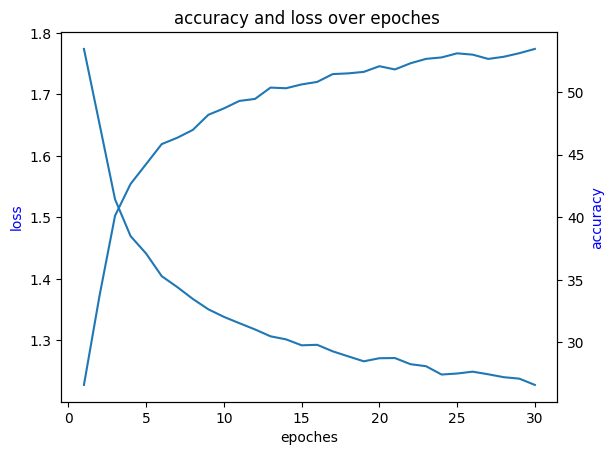

In [44]:
epoches=np.arange(1,31)


fig,ax1=plt.subplots()


ax1.plot(epoches,train_loss,label='loss')
ax1.set_xlabel('epoches')
ax1.set_ylabel('value')
ax1.set_ylabel('loss',color='b')


ax2=ax1.twinx()
ax2.plot(epoches,train_acc,label='accuracy')
ax2.set_ylabel('accuracy',color='b')

plt.title('accuracy and loss over epoches ')
plt.show()


In [ ]:
torch.save(model1.state_dict(),"models/modelv6.pth")

In [ ]:
#load the model 
model1.load_state_dict(torch.load("models/modelv6.pth"))

<All keys matched successfully>

In [115]:
model1.eval()
test_loss=0
correct=0
y_true=[]
y_pred=[]
with torch.no_grad():
    for inputs ,labels in test_loader :
        output=model1(inputs)
        loss=criterion(output,labels)
        test_loss +=loss.item()
        _, predicted=torch.max(output,1)
        
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())
    


In [116]:
accuracy=accuracy_score(y_true,y_pred)
print(accuracy)

0.5600445806631373


## VGG6-like model definition for emotion detection

In [1]:

import torch.nn as nn
class VGG6(nn.Module):
    def __init__(self, num_classes=7):
        super(VGG6, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 6 * 6, 256),  # Adjust if input size changes
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = VGG6(num_classes=len(train_dataset.classes)).to(device)
print(model)

KeyboardInterrupt: 

In [121]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [122]:
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, num_epochs=20)

Epoch 1 | Loss: 1.7496 | Accuracy: 28.16%
Epoch 2 | Loss: 1.5108 | Accuracy: 41.02%
Epoch 3 | Loss: 1.3822 | Accuracy: 46.73%


KeyboardInterrupt: 

In [32]:
torch.save(model.state_dict(),"models/modelvgg6_like.pth")

In [33]:
# testing on the test set
model.eval()
test_loss=0
correct=0
y_true=[]
y_pred=[]
with torch.no_grad():
    for inputs ,labels in test_loader :
        output=model(inputs)
        loss=criterion(output,labels)
        test_loss +=loss.item()
        _, predicted=torch.max(output,1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        
accuracy=accuracy_score(y_true,y_pred)

print(accuracy)

print(classification_report(y_true,y_pred,target_names=train_dataset.classes))

0.5798272499303427
              precision    recall  f1-score   support

       angry       0.48      0.53      0.50       958
   disgusted       0.66      0.40      0.49       111
     fearful       0.41      0.38      0.40      1024
       happy       0.78      0.80      0.79      1774
     neutral       0.54      0.49      0.52      1233
         sad       0.45      0.45      0.45      1247
   surprised       0.71      0.74      0.73       831

    accuracy                           0.58      7178
   macro avg       0.57      0.54      0.55      7178
weighted avg       0.58      0.58      0.58      7178



In [14]:
from torchvision import models
import torch.nn as nn

# Load VGG16 model (pretrained or not)
model = models.vgg16(pretrained=False)

# Modify the classifier for  number of classes ( 7 for emotion detection)
model.features[0]=nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 7)

# Move to device
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_losses, train_accuracies = train_model(model, train_loader, criterion, optimizer, num_epochs=20)